# MobileNetV2: 2 - Model on Masked CLAHE equalized images

As we work on Kaggle, this notebook has 2 parts: 
- a common part where we generate the masked CLAHE images dataset for the MobileNetV2 121 model,
- a specific part where we:
    - perform the model training with the best hyperparameters on the masked CLAHE images dataset
    - fine tune the model
    - do a grad cam analyses
    
## Common part: setting up the Working Environment and creating datasets

### Working Evironment

#### Colab

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 10 06:37:32 2024       



+---------------------------------------------------------------------------------------+



| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |



|-----------------------------------------+----------------------+----------------------+



| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |



| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |



|                                         |                      |               MIG M. |



|=========================================+======================+======================|



|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |



| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |



|                                         |                      |                  N/A |



+----------------------------------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM







You are using a high-RAM runtime!


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [ ]:
from google.colab import files

files.upload()
# import du kaggle.json dans C:\Users\Florent\.kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"floday","key":"07537b35a9bd77d1988340db0a763cf7"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'anasmohammedtahir/covidqu'

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu



License(s): CC-BY-SA-4.0






 98% 1.13G/1.15G [00:11<00:00, 63.3MB/s]



100% 1.15G/1.15G [00:11<00:00, 103MB/s] 


In [ ]:
! mkdir covidqu_data
! unzip covidqu.zip -d covidqu_data

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00





In [ ]:
! mkdir working
! mkdir working/COVID-EX-Qu-dataset

#### Kaggle

In [1]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-05-16 15:37:59.347693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 15:37:59.347784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 15:37:59.476660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Imports

In [2]:
# Standard library imports
import os
import shutil

# Related third party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from tqdm import tqdm

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Keras Tuner imports
from keras_tuner import BayesianOptimization, HyperModel, RandomSearch


### Variables

In [3]:
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']

# Colab
# base_path = '/content/covidqu_data/Lung Segmentation Data/Lung Segmentation Data'
# destination_path = '/content/working/COVID-EX-Qu-dataset'

# Kaggle
dataset_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
working_path = '/kaggle/working/COVID-EX-Qu-dataset'
source_images_path = os.path.join(working_path, 'source')

# Structure pour le modele
images_path = os.path.join(working_path, 'model','images')
clahe_images_path = os.path.join(working_path, 'model','normalized_images')
masked_normalized_images_path = os.path.join(working_path, 'model', 'masked_normalized_images')


### Data structure: creating the dataset

#### Copy source images and lung masks from Kaggle dataset

In [4]:
def copy_images(base_path, destination_path, sets, groups, folders, replace=False):
    """
    Copies image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        folders (list): A list of image types inside 'groups' folders, e.g., ['images', 'lung masks'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        
        for group in groups:
            image_dir = os.path.join(base_path, sett, group)
            
            for folder in folders:
                source_path = os.path.join(image_dir, folder)
                destination_dir = os.path.join(destination_path, sett, group, folder)
                
                if os.path.exists(destination_dir):
                    if replace:
                        shutil.rmtree(destination_dir)
                        shutil.copytree(source_path, destination_dir)
                        print(f"Replaced the directory {destination_dir}")
                    else:
                        print(f"The directory {destination_dir} already exists.")
                else:
                    shutil.copytree(source_path, destination_dir)
                    print(f"Copied to {destination_dir}")

In [5]:
copy_images(
    base_path=dataset_path, 
    destination_path=source_images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images', 'lung masks'],
    replace=False
)

The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/so

In [6]:
def check_data_integrity(destination_path, sets, groups, ref_covid, ref_noncovid, ref_normal):
    """
    Checks the integrity of data by counting the number of images in each category
    and comparing them to reference values. Displays three random images from each set and group in grayscale,
    with all text outputs printed after image displays.

    Args:
        destination_path (str): The directory where image data has been copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        ref_covid (int): Reference number of COVID-19 images.
        ref_noncovid (int): Reference number of Non-COVID images.
        ref_normal (int): Reference number of Normal images.
    """
    n_covid = 0
    n_noncovid = 0
    n_normal = 0
    outputs = []

    for sett in sets:
        for group in groups:
            ima_dir = os.path.join(destination_path, sett, group, 'images')
            image_files = os.listdir(ima_dir)
            num_images = len(image_files)
            outputs.append(f"In the set {sett}, there are {num_images} images of {group}")

            if num_images > 0:
                # Randomly select 3 images to display, or fewer if there are less than 3.
                sample_images = random.sample(image_files, min(3, num_images))

                # Displaying the images using matplotlib
                fig, axes = plt.subplots(1, min(3, num_images), figsize=(15, 5))
                for idx, img_name in enumerate(sample_images):
                    img_path = os.path.join(ima_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    axes[idx].imshow(img, cmap='gray')
                    axes[idx].axis('off')
                    axes[idx].set_title(f"{group} ({sett})")
                plt.show()

            if group == "COVID-19":
                n_covid += num_images
            elif group == "Non-COVID":
                n_noncovid += num_images
            elif group == "Normal":
                n_normal += num_images

    outputs.append(f"\nThere are {n_covid} COVID images found, {n_covid / ref_covid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_noncovid} non-COVID images, {n_noncovid / ref_noncovid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_normal} normal images, {n_normal / ref_normal * 100:.2f}% of the original dataset from Kaggle.")

    for output in outputs:
        print(output)

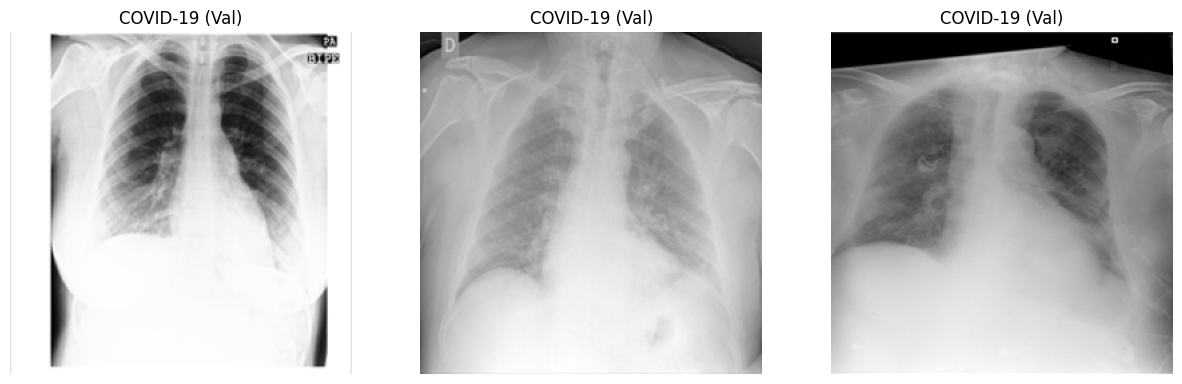

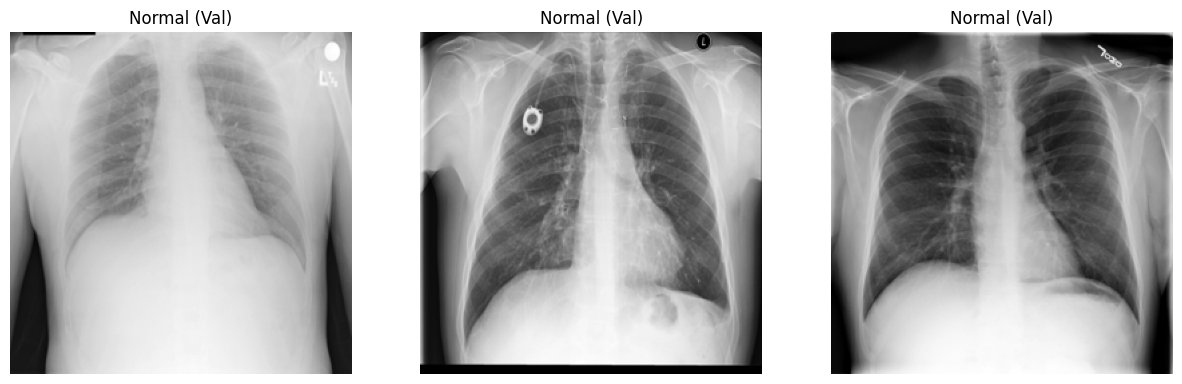

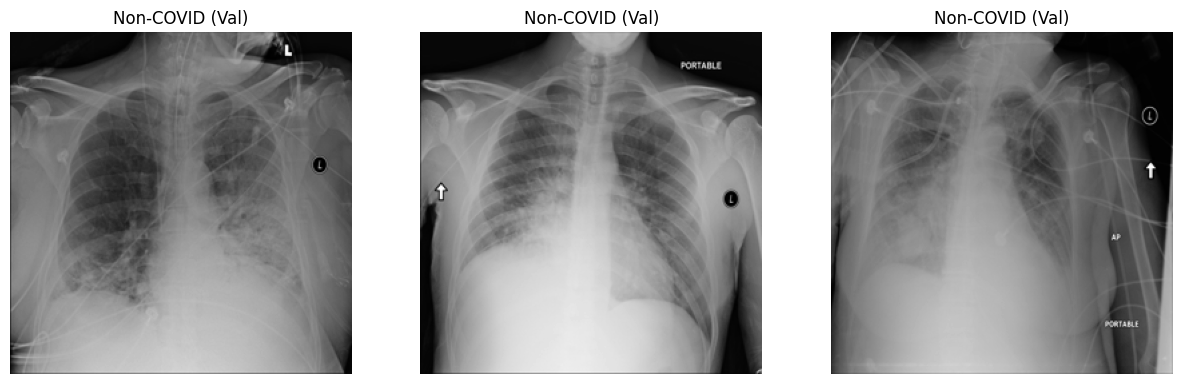

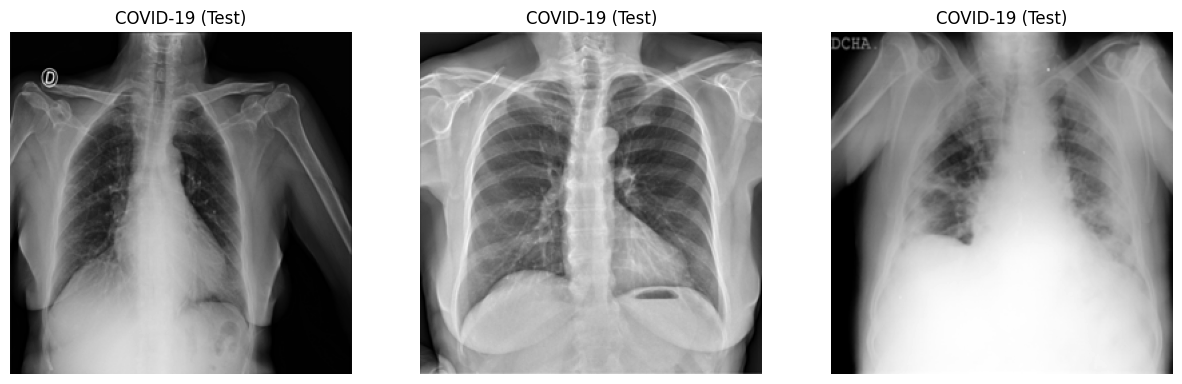

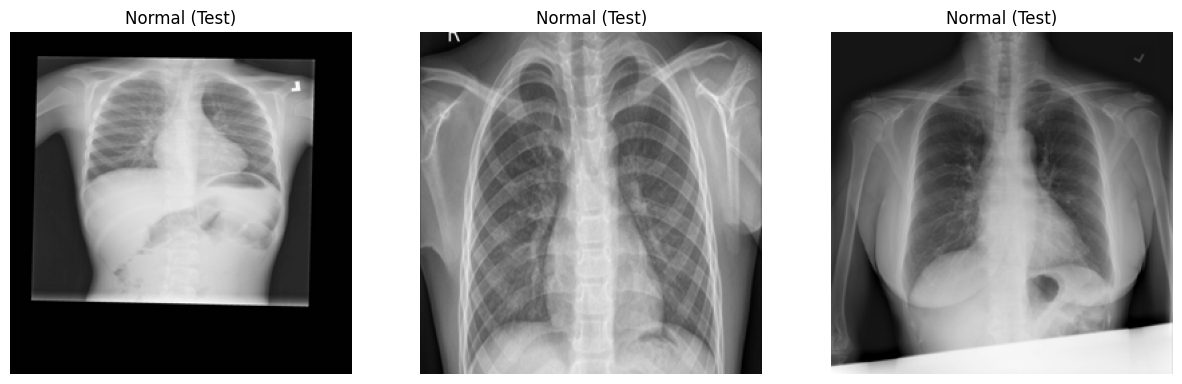

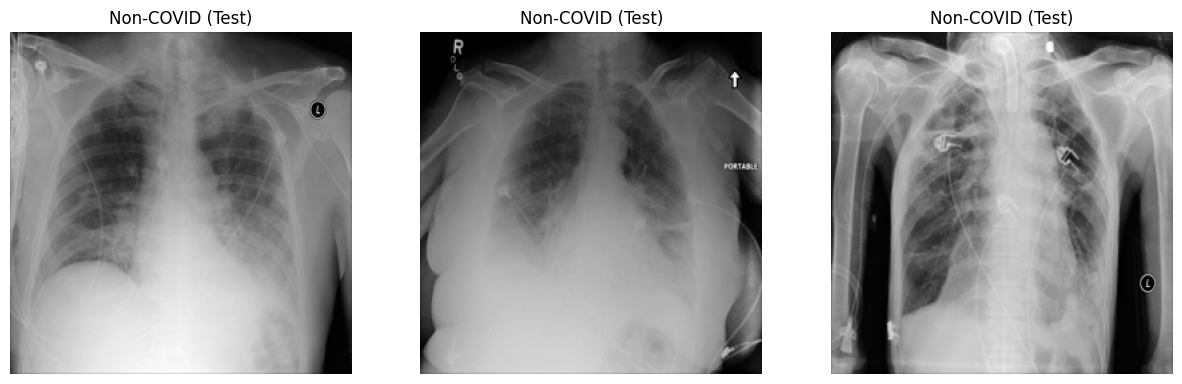

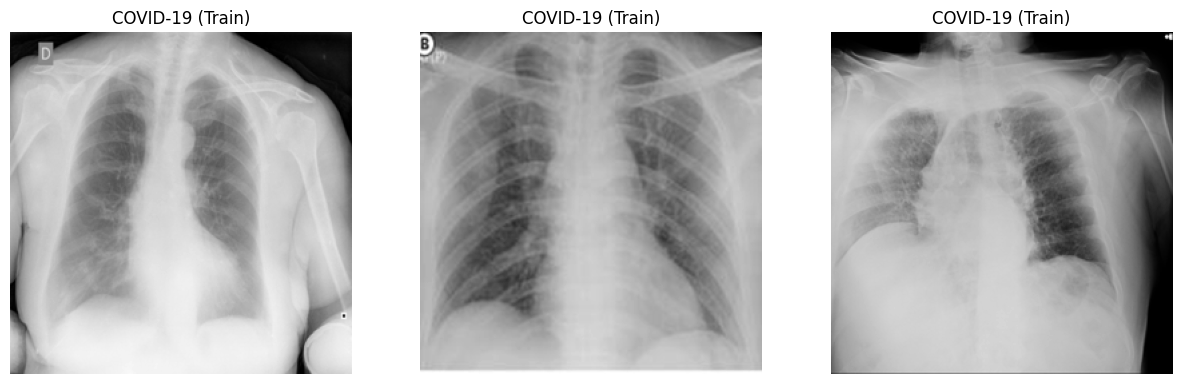

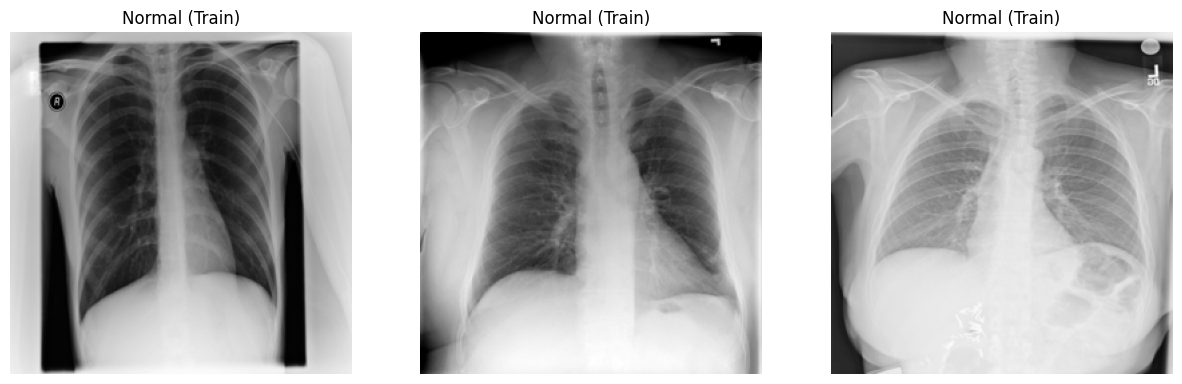

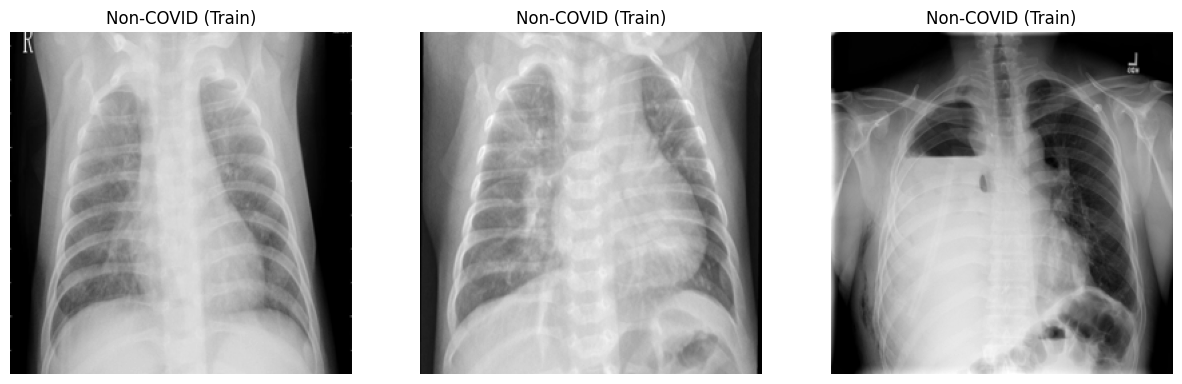

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.00% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.00% of the original dataset from Kaggle.
There are 10701 normal images, 100.00% of the original dataset from Kaggle.


In [7]:
check_data_integrity(destination_path=source_images_path, sets=sets, groups=groups, ref_covid=11956, ref_noncovid=11263, ref_normal=10701)

#### Data and folders structure for the model 

A specific data structure is expected for the model: one folder per set (Val, Test, Train) and a subfolder per group containing all the images. Therefore, this directory structure must be replicated for both the images and the masked images.

##### Raw images

In [8]:
copy_images(
    base_path=source_images_path , 
    destination_path=images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images'],
    replace=False)

The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Non-COVID/images already exists.


##### CLAHE Normalized images

Apply CLAHE on images in 'images_path' and save the results in 'clahe_images_path'.

In [9]:
def apply_clahe_normalization(img):
    """
    Apply CLAHE normalization to an input image.

    Args:
        img (numpy.ndarray): Input image, either in grayscale or RGB format.

    Returns:
        numpy.ndarray: CLAHE normalized image.

    Raises:
        ValueError: If the input image is None or not a valid image.
    """
    if img is None:
        raise ValueError("No image data received!")

    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray")

    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) != 2:  # Not a grayscale or RGB image
        raise ValueError("Input image must be either grayscale or RGB")

    # Ensure image is of type uint8 (required for CLAHE)
    if img.dtype != np.uint8:
        img = img.astype('uint8')

    # Apply CLAHE transformation
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    return img

In [10]:
def copy_and_clahe_images(base_path, destination_path, sets, groups, folders, replace=False):
    """
    Copy and apply CLAHE normalization on image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        folders (list): A list of image types inside 'groups' folders, e.g., ['images', 'lung masks'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        for group in groups:
            for folder in folders:
                base_dir = os.path.join(base_path, sett, group, folder)
                destination_dir = os.path.join(destination_path, sett, group, folder)
                
                if os.path.exists(destination_dir):
                    if replace:
                        shutil.rmtree(destination_dir)
                        os.makedirs(destination_dir)
                        print(f"Replaced the directory {destination_dir}")
                    else:
                        print(f"The directory {destination_dir} already exists.")
                        continue
                else:
                    os.makedirs(destination_dir)
                    print(f"Copied to {destination_dir}")
                
                # Process each image file individually
                for filename in tqdm(os.listdir(base_dir)):
                    base_file_path = os.path.join(base_dir, filename)
                    destination_file_path = os.path.join(destination_dir, filename)
                    
                    # Read the image
                    img = cv2.imread(base_file_path, cv2.IMREAD_UNCHANGED)
                    if img is not None:
                        # Apply CLAHE normalization
                        normalized_img = apply_clahe_normalization(img)
                        
                        # Normalize the image to [0, 1]
#                         img = img.astype('float32') / 255.0
                        
                        # Save the normalized image
                        cv2.imwrite(destination_file_path, normalized_img)
                    else:
                        print(f"Failed to read {source_path}")

In [11]:
copy_and_clahe_images(
    base_path=source_images_path ,
    destination_path=clahe_images_path ,
    sets=sets,
    groups=groups,
    folders=['images'],
    replace=False
)

The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/Non-COVID/images already exists.


##### Masked CLAHE normalized images

Apply masks on CLAHE normalized images in 'clahe_images_path' and save the results in 'masked_normalized_images_path'.

In [12]:
def apply_black_mask(image, mask):
    """
    Apply a black mask to an image, keeping the content in white areas of the mask.
    
    Args:
        image (numpy.ndarray): The original image.
        mask (numpy.ndarray): The mask image, where white areas will be kept and black areas masked.
    
    Returns:
        numpy.ndarray: The resulting image with the mask applied.
    """
    # Resize the mask to match the dimensions of the image (if necessary)
    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Perform bitwise AND operation to keep content in white areas of the mask
    masked_content = cv2.bitwise_and(image, image, mask=mask)

    # Create a black image of the same size as the original image
    black_image = np.zeros_like(image)

    # Perform bitwise AND operation to keep black areas of the mask
    black_areas = cv2.bitwise_and(black_image, black_image, mask=mask)

    # Combine the masked content and black areas using bitwise OR operation
    masked_image = cv2.bitwise_or(masked_content, black_areas)
   
    return masked_image

In [13]:
def dilate_and_apply_black_mask(mask, nb_pixels, image, file, masked_image_path):    
    """
    Apply the apply_black_mask function with a dilated mask and save the resulting image.
    
    Args:
        mask (numpy.ndarray): The mask image.
        nb_pixels (int): The size of the dilation kernel.
        image (numpy.ndarray): The original image.
        file (str): The filename of the original image.
        masked_image_path (str): The path where the resulting image will be saved.
    """
    kernel = np.ones((nb_pixels, nb_pixels), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel)

    masked_image = apply_black_mask(image=image, mask=dilated_mask)
    
    file_name = "masked_" + file
    output_path = os.path.join(masked_image_path, file_name)
    
    cv2.imwrite(output_path, masked_image)
    

In [14]:
def apply_mask(destination_path, sets, groups, replace=False):
    """
    Copy and apply the corresponding mask on image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        print(sett)
        for group in groups:
            print(group)
            base_mask_dir = os.path.join(source_images_path , sett, group, 'lung masks')
            base_image_dir = os.path.join(clahe_images_path , sett, group, 'images')
            destination_dir = os.path.join(destination_path, sett, group, 'images')
                
            if os.path.exists(destination_dir):
                if replace:
                    shutil.rmtree(destination_dir)
                    os.makedirs(destination_dir)
                    print(f"Replaced the directory {destination_dir}")
                else:
                    print(f"The directory {destination_dir} already exists.")
                    continue
            else:
                os.makedirs(destination_dir)
                print(f"Copied to {destination_dir}")

            for filename in tqdm(os.listdir(base_mask_dir)):

                base_mask_path = os.path.join(base_mask_dir, filename)
                base_image_path = os.path.join(base_image_dir, filename)
                
                image = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(base_mask_path, cv2.IMREAD_GRAYSCALE)               
                
                if image is None:
                    print("Error: Unable to read image file")
                    print(image_file, "\n",  mask_file)
                    exit()
                elif mask is None:
                    print("Error: Unable to read mask file")
                    print(image_file, "\n",  mask_file)
                    exit()
                    
                dilate_and_apply_black_mask(
                    mask=mask, 
                    nb_pixels=3, 
                    image=image, 
                    file=filename,
                    masked_image_path=destination_dir)

In [15]:
apply_mask(
    destination_path=masked_normalized_images_path , 
    sets=sets, 
    groups=groups, 
    replace=False)

Val
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/Normal/images already exists.
Non-COVID
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/Non-COVID/images already exists.
Test
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/Normal/images already exists.
Non-COVID
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/Non-COVID/images already exists.
Train
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Train/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Train/Normal/i

##### Check processed images

In [16]:
def display_random_images_from_sets(base_path, sets, groups, num_images=3):
    """
    Display random images from each set and group in the specified base path.

    Args:
        base_path (str): The base directory containing the images.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        num_images (int): The number of random images to display from each set and group.
    """
    for sett in sets:
        for group in groups:
            image_dir = os.path.join(base_path, sett, group, 'images')
            all_images = os.listdir(image_dir)
            random_images = random.sample(all_images, min(len(all_images), num_images))
            
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{sett} - {group}", fontsize=16)
            
            for i, image_name in enumerate(random_images):
                image_path = os.path.join(image_dir, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(image, cmap='gray')
                plt.title(image_name)
                plt.axis('off')
            
            plt.show()

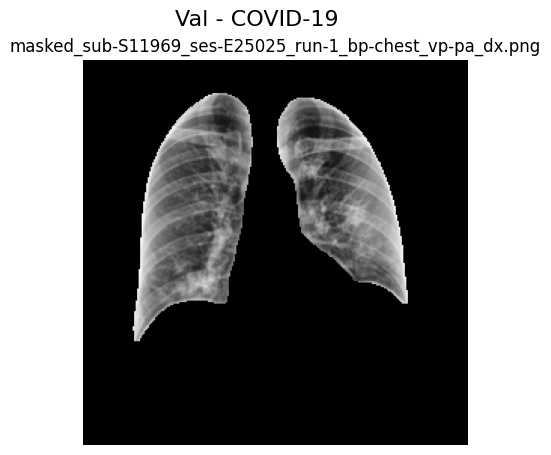

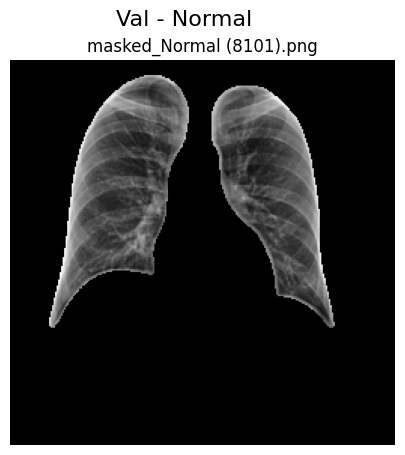

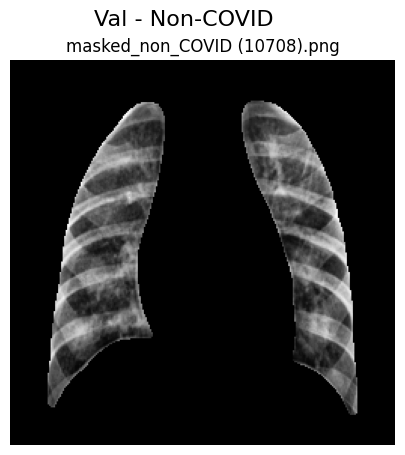

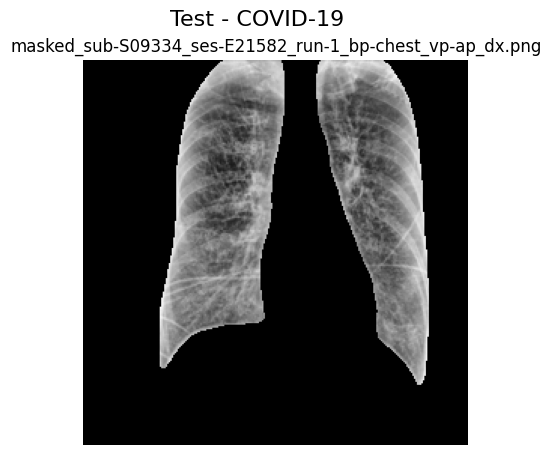

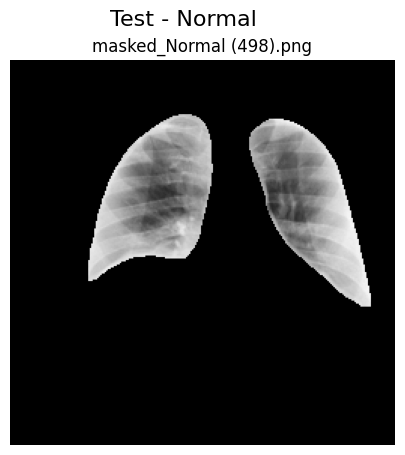

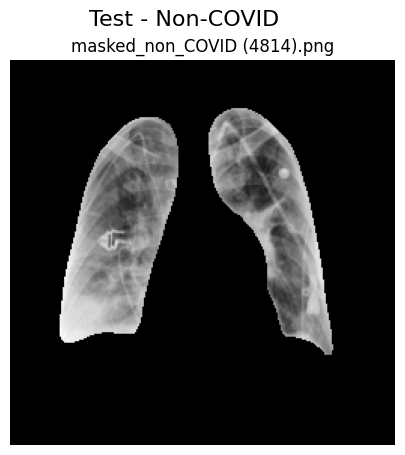

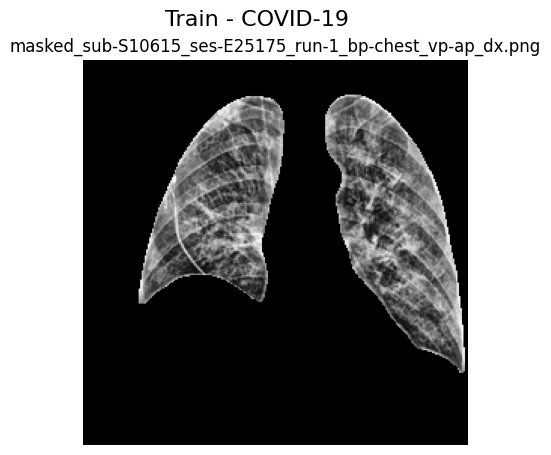

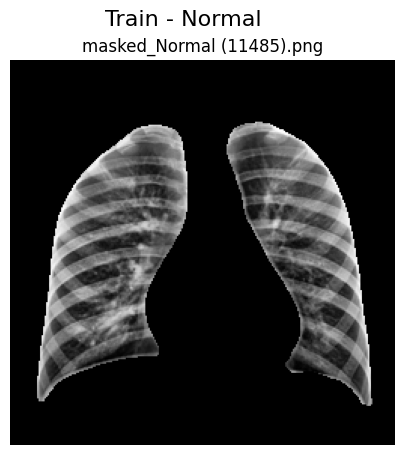

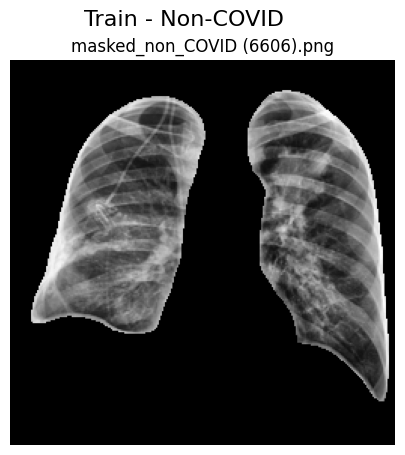

In [17]:
display_random_images_from_sets(base_path=masked_normalized_images_path, sets=sets, groups=groups, num_images=1)

## Specific part: Model 

### Data generator

In [18]:
# pre processing pour le modele
# d'apres Keras : input shape has to be (224, 224, 3)
# normalisation : deja fait
# densent est construit pour fonctionner en rgb : l faut donc repliquer la couche 3x comme les radios sont en gris

def preprocess_image(img):
    """
    Preprocess the image for DenseNet121 input.

    Args:
        img (numpy.array): Input image array.

    Returns:
        numpy.array: Preprocessed image array.
    """
    if img is None:
        raise ValueError("No image data received!")

    # Convert grayscale to RGB only if the image is grayscale
    if len(img.shape) == 2 or img.shape[2] == 1:  # Check if the image is grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    img = cv2.resize(img, (224, 224))
    
    # Rescale pixel values to [0, 1]
    img = img / 255.0

    return img

In [19]:
# Initialize the ImageDataGenerator with the preprocessing function

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

In [20]:
# Preparation of the data set using image generator

def data_generator(data_path:str, dataset:str, shuffle, batch_size=32):
    """
    Generates batches of tensor image data with real-time data augmentation.

    The data will be looped over (in batches) indefinitely.

    Args:
        data_path (str): Main directory name
        dataset (str): The subdirectory name (e.g., 'Train', 'Test', 'Val') within the destination path which contains the image data.
        shuffle (bool): Whether to shuffle the images before outputting to the batch.
        batch_size (int): Number of images to be included in each batch (default is 32, to optimize resources and a slow convergence for a better generalization).

    Returns:
        DirectoryIterator: An iterator that returns batches of preprocessed images and labels as per the specified batch size and target size.
    """
    generator = datagen.flow_from_directory(
        directory=os.path.join(data_path, dataset), # images stored in directories that represent their class labels
        target_size=(224, 224), # resizes all images to 224x224 pixels
        batch_size=batch_size, # defines how many images are processed at once
        class_mode='sparse', #'categorical' converts class labels to one-hot encoded vectors
        color_mode='rgb',  # Ensure images are loaded as grayscale
        shuffle=shuffle)

    return generator

In [21]:
train_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Train", shuffle=True)
test_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Test", shuffle=False) # shuffle=False argument is very important for model evaluation
val_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Val", shuffle=False)

Found 21715 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.


In [22]:
# verification
for x_batch, y_batch in data_generator(data_path=masked_normalized_images_path, dataset='Train', shuffle=True):
    print(x_batch.shape)  # Should show (32, 224, 224, 3) if full batch
    print(y_batch.shape)  # Should show (32, num_classes) for one-hot encoded labels or (32,) for sparse labels
    break  # Just check the first batch

Found 21715 images belonging to 3 classes.
(32, 224, 224, 3)
(32,)


In [22]:
def display_sample_images(data_path, groups, sets, num_samples=3):
    """
    Displays sample images for each class from each dataset.

    Args:
        groups (list): List of class names, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        sets (list): List of dataset names, e.g., ['Val', 'Test', 'Train'].
        num_samples (int): Number of images to display per class.
    """
    for set_name in sets:
        print(f"--- Displaying images from the {set_name} set ---")
        generator = data_generator(data_path=data_path, dataset=set_name, shuffle=False, batch_size=32)  # Batch size can be adjusted if necessary
        for group in groups:
            print(f"Class: {group}")
            found = 0
            images, labels = [], []
            # Reset the generator to ensure reproducibility
            generator.reset()
            for img_batch, label_batch in generator:
                for img, label in zip(img_batch, label_batch):
                    if generator.class_indices[group] == label:
                        images.append(img)
                        labels.append(label)
                        found += 1
                        if found >= num_samples:
                            break
                if found >= num_samples:
                    break
            # Display the images
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            for i in range(num_samples):
                axes[i].imshow(images[i].squeeze())
                axes[i].axis('off')
                axes[i].set_title(f"{group}")
            plt.show()


In [ ]:
# display_sample_images(data_path=masked_normalized_images_path, groups=groups, sets=sets)

### Model building

### Tuning: already done

In [23]:
# callback: Early stopping to speed up tuning
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # restore_best_weights : garde les weighs de l'epoch avec la meilleure val_loss

In [24]:
# best hyperparameters (from 04_fd_densenet121_1_tuning.ipynb): 
best_units_1 = 1024
best_dropout_1 = 0.1
best_learning_rate = 0.0001

### Model Training with the best hyperparameters

In [25]:
# Model building with functional API

def build_best_model(fine_tune=False):
    # Load the MobileNetV2 base model, pre-trained on ImageNet
    base_model = MobileNetV2(
        include_top=False,  # Exclude top layers
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Freeze the convolutional base to reuse the learned features
    if not fine_tune:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        print("Unfreezing layers:")
        # Unfreeze the last dense block (adjust as per MobileNetV2 layer names)
        for layer in base_model.layers:
            if 'block_13_expand' in layer.name or 'block_16_project' in layer.name:
                layer.trainable = True
                print("Trainable layer:", layer.name)

    # Define the input
    inputs = Input(shape=(224, 224, 3))

    # Apply the base model
    x = base_model(inputs, training=fine_tune)
    # Add global average pooling
    x = GlobalAveragePooling2D()(x)
    # Add a fully connected layer
    x = Dense(units=best_units_1, activation='relu')(x)
    # Add dropout
    x = Dropout(rate=best_dropout_1)(x)
    # Add the output layer
    outputs = Dense(3, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)

    # Compile the model with a smaller learning rate if fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=0.00001 if fine_tune else best_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [26]:
best_model = build_best_model(fine_tune=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Explicitly build model if not already built
if not best_model.built:
    best_model.build((None, 224, 224, 3))  # None for the batch size, and (224, 224, 3) is the input shape

best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 1,314,819 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
# New data generator with data augmentation to prevent overfitting during training :
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

In [29]:
train_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Train", shuffle=True)
test_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Test", shuffle=False)
val_data_generator = data_generator(data_path=masked_normalized_images_path, dataset="Val", shuffle=False)

Found 21715 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.


In [30]:
# verification
for x_batch, y_batch in data_generator(data_path=masked_normalized_images_path, dataset='Train', shuffle=True):
    print(x_batch.shape)  # Should show (32, 224, 224, 3) if full batch
    print(y_batch.shape)  # Should show (32, num_classes) for one-hot encoded labels
    break  # Just check the first batch

Found 21715 images belonging to 3 classes.
(32, 224, 224, 3)
(32,)


In [31]:
def display_model_structure():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        print(layer.name)

In [32]:
display_model_structure()

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

#### Training

In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = best_model.fit(train_data_generator,
          validation_data=val_data_generator,
          epochs=25,
          callbacks=[stop_early])

best_model.save_weights('mobilenetv2_trained.weights.h5')

Epoch 1/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - accuracy: 0.6790 - loss: 0.7221 - val_accuracy: 0.7305 - val_loss: 0.6119
Epoch 2/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.7644 - loss: 0.5604 - val_accuracy: 0.7881 - val_loss: 0.5168
Epoch 3/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.7831 - loss: 0.5280 - val_accuracy: 0.7853 - val_loss: 0.5175
Epoch 4/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.8018 - loss: 0.4877 - val_accuracy: 0.7990 - val_loss: 0.5001
Epoch 5/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.8027 - loss: 0.4817 - val_accuracy: 0.7992 - val_loss: 0.5008
Epoch 6/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.8129 - loss: 0.4617 - val_accuracy: 0.7932 - val_loss: 0.5064
Epoch 7/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.8200 - loss: 0.4449 - val_accuracy: 0.8121 - val_loss: 0.4662
Epoch 8/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.8265 - loss: 0.4300 - 

#### Eval

In [30]:
best_model.load_weights('mobilenetv2_trained.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [29]:
results = best_model.evaluate(test_data_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/213 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9284 - loss: 0.2347

I0000 00:00:1715859036.544247     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.8457 - loss: 0.3874


In [30]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 0.4320710301399231
Test accuracy: 0.8269004225730896


NameError: name 'history' is not defined

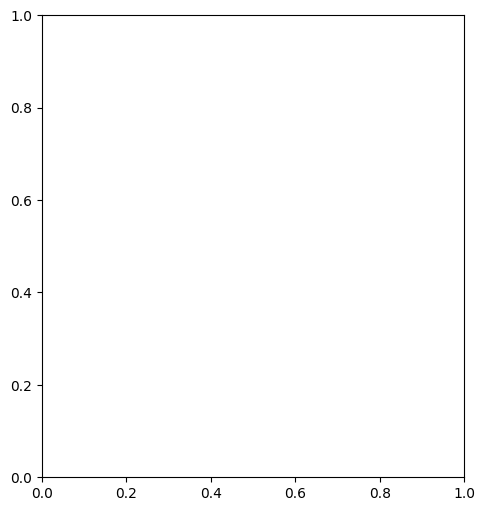

In [31]:
# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
# Get the predictions and true classes
predictions = best_model.predict(test_data_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/213 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step

I0000 00:00:1715874307.623733     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step


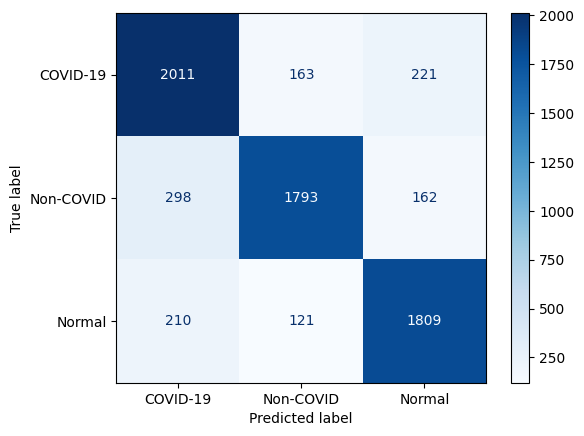

In [32]:
# Compute the confusion matrix
cm = metrics.confusion_matrix(true_classes, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [33]:
# Generate and print the classification report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    COVID-19       0.80      0.84      0.82      2395
   Non-COVID       0.86      0.80      0.83      2253
      Normal       0.83      0.85      0.84      2140

    accuracy                           0.83      6788
   macro avg       0.83      0.83      0.83      6788
weighted avg       0.83      0.83      0.83      6788



### Fine tuning

In [34]:
# fine tuning
# unfreeze le dernier bloc seulement ou qq layers de ce dernier bloc, comme l'échantillon est tres différent d'image net, sinon on, va overfit
# il faut diminuer le learning rate

best_model_fine_tuned = build_best_model(fine_tune=True)

Unfreezing layers:
Trainable layer: block_13_expand
Trainable layer: block_13_expand_BN
Trainable layer: block_13_expand_relu
Trainable layer: block_16_project
Trainable layer: block_16_project_BN


#### Eval of the fine tuned model

In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = best_model_fine_tuned.fit(train_data_generator,
          validation_data=val_data_generator,
          epochs=25,
          callbacks=[stop_early])

best_model_fine_tuned.save_weights('mobilenetv2_fine_tuned.weights.h5')

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


679/679 ━━━━━━━━━━━━━━━━━━━━ 164s 156ms/step - accuracy: 0.6262 - loss: 0.8092 - val_accuracy: 0.3539 - val_loss: 1.7606
Epoch 2/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.7965 - loss: 0.4961 - val_accuracy: 0.3906 - val_loss: 1.5235
Epoch 3/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.8361 - loss: 0.4055 - val_accuracy: 0.4820 - val_loss: 1.1890
Epoch 4/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.8663 - loss: 0.3427 - val_accuracy: 0.5490 - val_loss: 1.0634
Epoch 5/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.8885 - loss: 0.2870 - val_accuracy: 0.5765 - val_loss: 1.0318
Epoch 6/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - accuracy: 0.9114 - loss: 0.2391 - val_accuracy: 0.5837 - val_loss: 1.0782
Epoch 7/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - accuracy: 0.9273 - loss: 0.1988 - val_accuracy: 0.6251 - val_loss: 1.0553
Epoch 8/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 66s 97ms/step - accuracy: 0.9415 - loss: 0.1654 - val_accur

In [35]:
best_model_fine_tuned.load_weights('mobilenetv2_fine_tuned.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [36]:
results_fine_tuned = best_model_fine_tuned.evaluate(test_data_generator)

213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.8487 - loss: 0.4817


In [37]:
print(f"Test loss: {results_fine_tuned[0]}")
print(f"Test accuracy: {results_fine_tuned[1]}")

Test loss: 0.46781522035598755
Test accuracy: 0.8525338768959045


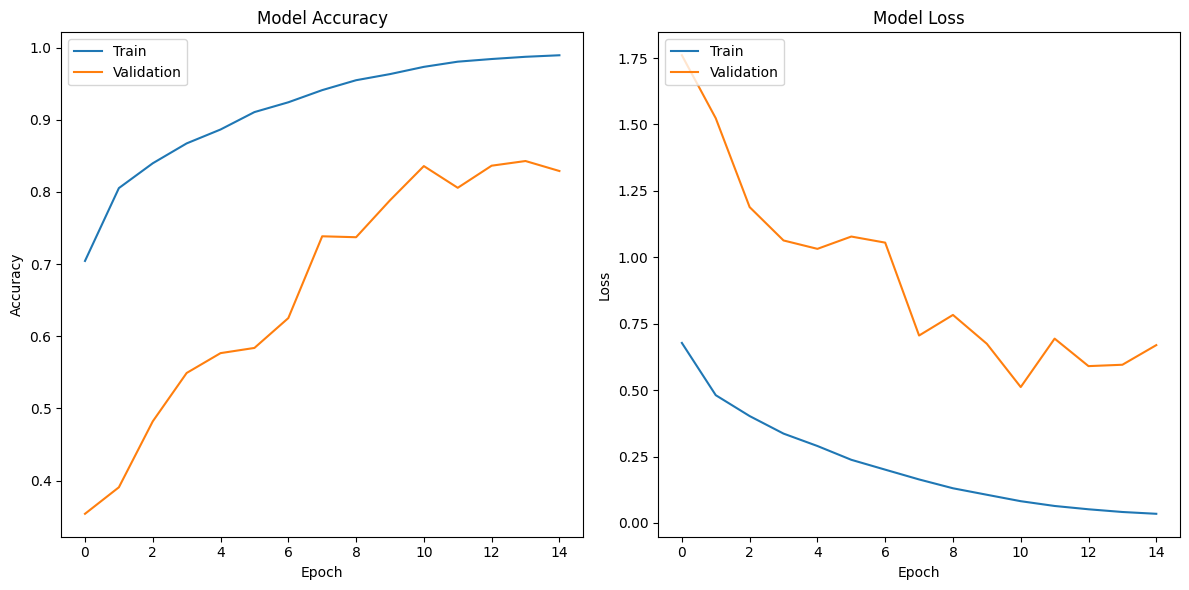

In [39]:
# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
# Get the predictions and true classes
predictions = best_model_fine_tuned.predict(test_data_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())


213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step


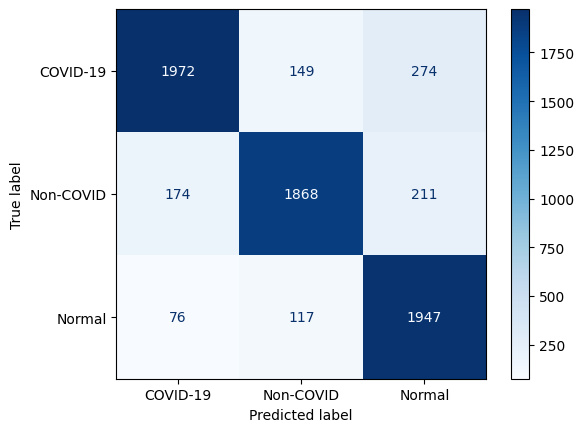

In [39]:
# Compute the confusion matrix
cm = metrics.confusion_matrix(true_classes, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [41]:
# Generate and print the classification report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    COVID-19       0.89      0.82      0.85      2395
   Non-COVID       0.88      0.83      0.85      2253
      Normal       0.80      0.91      0.85      2140

    accuracy                           0.85      6788
   macro avg       0.85      0.85      0.85      6788
weighted avg       0.86      0.85      0.85      6788



### Apply model and display predictions

In [ ]:
best_model_fine_tuned = build_best_model(fine_tune=True)
best_model_fine_tuned.load_weights('mobilenetv2_fine_tuned.weights.h5')

In [42]:
# Visualization of results on images from test_generator data:
class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}

# Function to apply the model on a batch of images and visualize the results
def apply_model_and_visualize_multiple_images(model, data_generator, num_images=12):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        # Retrieve one image and its label from the generatorl 
        batch_images, batch_labels = random.choice(data_generator)
        image = batch_images[0]  # Take the first image from the batch
        label = round(batch_labels[0])  # Corresponding label
        
        # Reshape the image to (1, height, width, channels) for model prediction
        image = np.expand_dims(image, axis=0)
        
        # Apply the trained model to obtain prediction
        prediction = model.predict(image)
        
        # Round the predicted label to the nearest integer
        predicted_label = np.argmax(prediction)
        
        # Convert integer labels to class names
        true_class_name = class_names[label]
        predicted_class_name = class_names[predicted_label]
        
        # Modify the image to have a good contrast
        contrasted_image = (batch_images[0]+1)*127.5
        contrasted_image = keras.utils.array_to_img(contrasted_image)
        
        # Visualize the result
        plt.subplot(4, 3, i+1)
        plt.imshow(contrasted_image)
        
        # Determine title color based on whether true and predicted labels match
        title_color = 'green' if true_class_name == predicted_class_name else 'red'
        
        plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}", color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


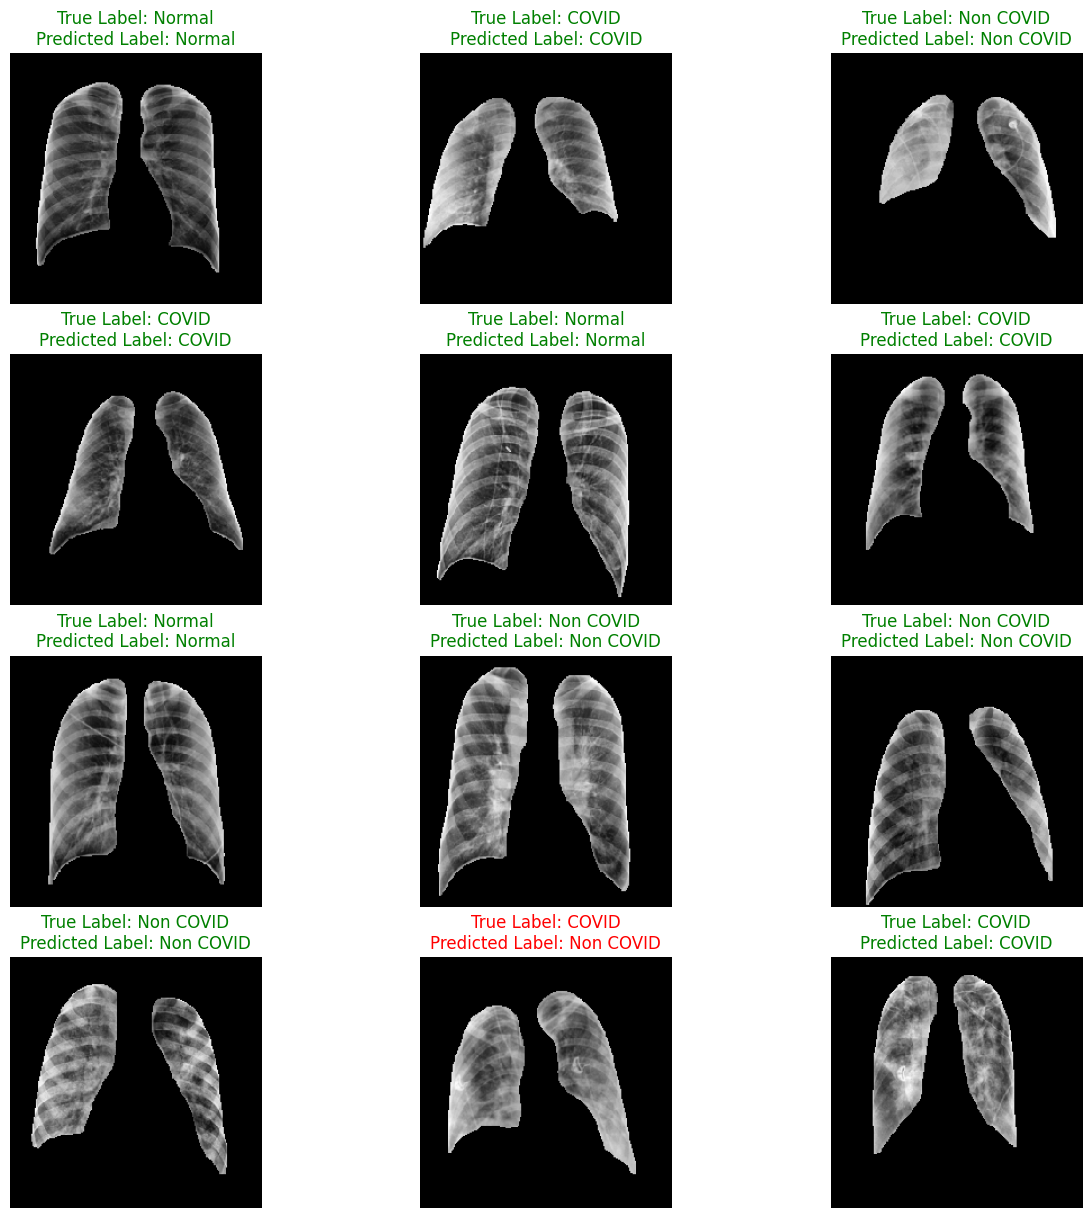

In [43]:
# Example usage for applying the model on multiple images from the test set
apply_model_and_visualize_multiple_images(best_model_fine_tuned, test_data_generator)

### Interpretability: GRAD CAM

In [59]:
last_conv_layer_name = "block_16_project_BN"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(inputs = model.input, outputs = [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_319>

In [60]:
def save_and_display_gradcam(img, heatmap, alpha=0.005):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    plt.axis('off')
    plt.imshow(superimposed_img)

In [61]:
num_images_to_process = 10
model = best_model_fine_tuned
model.layers[-1].activation = None

# Iterate through the images
for i in range(num_images_to_process):
    # Select images randomly
    batch_image, batch_label = random.choice(test_data_generator)
    image = batch_image[i] 
    image = np.expand_dims(image, axis=0)
    
    # Normalize the image for the superimposition (between 0 and 1)
    contrasted_image = (batch_image[i]+1)/2
    contrasted_image
    
    # Make the prediction
    prediction = model.predict(image)
    
    # Create the heatmap
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
    
    # Resize the heatmap to the original image size
    heatmap = tf.expand_dims(heatmap, axis=-1)  # Add an extra channel dimension
    heatmap = tf.image.resize(heatmap, (contrasted_image.shape[0], contrasted_image.shape[1]))

    # Convert the heatmap to numpy array
    heatmap = heatmap.numpy()
    heatmap = np.abs(heatmap-1) # Red and blue are reversed, probably because cv2 and tensorflow dont use the same default colors - This will make them appear as I want

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (jet or any other)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert heatmap to float32 and scale to [0, 1]
    heatmap = heatmap.astype(np.float32) / 255
    
    # Superimpose both images
    superimposed_img = cv2.addWeighted(contrasted_image, 0.5, heatmap, 0.5, 0)
    
    # Get predicted and true labels
    true_label = batch_label[i]
    true_class_name = class_names[true_label]
    predicted_label = np.argmax(prediction[0])
    predicted_class_name = class_names[predicted_label]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    # Plot the original image and the Grad-CAM heatmap
    plt.figure(figsize=(15, 5))
    plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i+1, predicted_class_name, true_class_name), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)
    plt.subplot(1, 2, 1)
    plt.imshow(contrasted_image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


ValueError: No such layer: block_16_project_BN. Existing layers are: ['input_layer_3', 'mobilenetv2_1.00_224', 'global_average_pooling2d_1', 'dense_2', 'dropout_1', 'dense_3'].